In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from itertools import combinations

In [4]:
from urdf_parser_py.urdf import URDF
from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE
from pkg.joint_utils import *
from pkg.ros_rviz import *

In [5]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.ur10 import *
from pkg.geometry import *
from pkg.collision import *
from pkg.distance import *
from pkg.distance_calculator import *
from pkg.binding_calculator import *
from pkg.graph_tf import *

In [6]:
gtimer = GlobalTimer()

# Make Graph

In [7]:
urdf_content = URDF.from_xml_file(URDF_PATH)
link_info_list = get_link_info_list(LINK_NAMES, urdf_content)
robot_info = RobotInfo(link_info_list, rname = "rbt0", base_frame=np.identity(4,dtype=np.float32))

In [8]:
gitem_list, gframe_dict= get_link_items_offsets(color=(0,1,0,0.5), display=False)
gitem_list += [
    GeometryItem(name='box1', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0.3,0.3,0.8,1), display=True, collision=True),
    GeometryItem(name='floor', gtype=GeoType.PLANE, dims=[3,3,0.01], color=(0.6,0.6,0.6,1), display=True, collision=True),
    GeometryItem(name='wall', gtype=GeoType.BOX, dims=[0.7,0.05,0.4], color=(0.4,0.3,0.0,1), display=True, collision=True),
    GeometryItem(name='stepper', gtype=GeoType.BOX, dims=[0.15,0.15,0.3], color=(0.4,0.3,0.0,1), display=True, collision=True),
    GeometryItem(name='goal_disp', gtype=GeoType.BOX, dims=[0.1,0.1,1e-3], color=(0.8,0.0,0.0,1), display=True, collision=False)
]
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,-0.2,0.050)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0,0,-0.00501)), "world"),
                    "wall":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.7,0.0,0.2)), "world"),
                    "stepper":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.4,0.4,0.15)), "world"),
                    "goal_disp":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.4,0.4,0.3)), "world")
                   })

In [9]:
N_sim = 32
N_joints = 9
DOF = 6


gtimer.tic("initialize")
binfo_list = [
    BindingInfo(
        name='vac1', btype=BindingType.VACC, obj_name='tool_mesh', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
    BindingInfo(
        name='boxtop', btype=BindingType.SUCC, obj_name='box1', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
    BindingInfo(
        name='boxbottom', btype=BindingType.SUCC, obj_name='box1', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,-0.05))), 
    BindingInfo(
        name='floortop', btype=BindingType.PLANE, obj_name='floor', gtype=None, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.005)))]
graph = GraphModel(robot_info=robot_info, gitem_list=gitem_list, binfo_list=binfo_list, urdf_content=urdf_content, 
                   N_sim=N_sim, learning_rate=5e-3, 
                   alpha_cl=0.00)
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
T_all, Tbo_all, Tbb_all = graph(None)
Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
res = graph.col_cal.calc_all(Tbo_all_res)
gtimer.toc("initialize")
print(gtimer)

initialize: 	12443.0 ms/1 = 12443.424 ms 



In [10]:
gtimer.reset()
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gtimer.tic("assign")
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(0,1)]]*N_sim)
gtimer.toc("assign")
print(gtimer)

assign: 	9.0 ms/1 = 8.858 ms 



# Prepare RVIZ

In [11]:

# prepare ros
pub, joints, rate_ros = get_publisher(JOINT_NAMES)
# prepare visualization markers
marker_list = set_markers(gitem_list, gframe_dict, urdf_content)
show_motion([np.array([0]*6)], marker_list, 
            [[gframe_dict[mk.geometry.name] for mk in marker_list]], 
            pub, joints, error_skip=1e-6, period=1e-6)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
publication OK - tool_mesh
publication OK - box1
publication OK - floor
publication OK - wall
publication OK - stepper
publication OK - goal_disp


# Show rviz

In [12]:
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,-0.2,0.05)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                   })
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                         graph.binding_name_list.index('boxtop'))]]+[[]]*(N_sim-1),
                     [[0]*graph.robot.DOF]*N_sim,
                     [[0]*graph.robot.DOF]+[[1]*graph.robot.DOF]+[[0]*graph.robot.DOF]*(N_sim-2))

In [13]:
Qcur = graph.get_Q()
q = np.array(Qcur[0])
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# loop display

In [14]:
gtimer.reset()
lpf = LowPassFilter(0.5)
for _ in range(100):
    gtimer.tic("calc")
    Qcur = graph.get_Q()
    T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
    jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
    jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
    Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
    b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
    mask_rot = tf.expand_dims(graph.bind_cal.mask_rot, axis=-1)
    b_dist_masked = b_dist_all*mask_rot
    jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
    jac_bind_masked = jac_bind*mask_rot
    jac_bind_tr = tf.transpose(jac_bind_masked, (0,2,1))
    jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind_masked,jac_bind_tr)+graph.bind_cal.mask_rot_diag_rev))
    jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    jac_ang_masked = jac_ang_stack*mask_rot
    jac_ang_tr = tf.transpose(jac_ang_masked, (0,2,1))
    jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_masked,jac_ang_tr)+graph.bind_cal.mask_rot_diag_rev))
    angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    angle_all_masked = angle_all_stack*mask_rot
    dQ = (
        K.sum(
            tf.matmul(jac_bind_inv,b_dist_masked) 
            + tf.matmul(jac_ang_inv,angle_all_masked), axis=-1)
        + graph.joint_mask_batch * (graph.joint_batch - Qcur))*graph.rate_update
    dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
    dQ_pre = lpf(dQ_clip)

    
    #cut collision
    dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
    Dcur = dist_all
    mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
    sign_jac_d =tf.sign(jac_d)
    dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
    dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer
    
    Qnew = Qcur+dQ_pre+dQ_cut

    gtimer.toc("calc")
    gtimer.tic("assign")
    graph.assign_Q(Qnew)
    gtimer.toc("assign")

    pose_list = [np.array(graph.get_Q()[0])]
    gframevec_list = [[gframe_dict[mk.geometry.name] for mk in marker_list]]
    show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
    timer.sleep(0.05)
print(gtimer)

calc: 	8914.0 ms/100 = 89.138 ms 
assign: 	49.0 ms/100 = 0.492 ms 



In [15]:
gframe_dict_list = graph.update_slack_frames(gframe_dict_list, T_all, Tbo_all)

# Show rviz

In [16]:
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('boxbottom'), 
                         graph.binding_name_list.index('floortop'))]]*N_sim)

In [17]:
Qcur = graph.get_Q()
q = np.array(Qcur[0])
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# loop display

In [18]:
gtimer.reset()
lpf = LowPassFilter(0.5)
for _ in range(100):
    gtimer.tic("calc")
    Qcur = graph.get_Q()
    T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
    jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
    jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
    Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
    b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
    mask_rot = tf.expand_dims(graph.bind_cal.mask_rot, axis=-1)
    b_dist_masked = b_dist_all*mask_rot
    jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
    jac_bind_masked = jac_bind*mask_rot
    jac_bind_tr = tf.transpose(jac_bind_masked, (0,2,1))
    jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind_masked,jac_bind_tr)+graph.bind_cal.mask_rot_diag_rev))
    jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    jac_ang_masked = jac_ang_stack*mask_rot
    jac_ang_tr = tf.transpose(jac_ang_masked, (0,2,1))
    jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_masked,jac_ang_tr)+graph.bind_cal.mask_rot_diag_rev))
    angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    angle_all_masked = angle_all_stack*mask_rot
    dQ = (
        K.sum(
            tf.matmul(jac_bind_inv,b_dist_masked) 
            + tf.matmul(jac_ang_inv,angle_all_masked), axis=-1)
        + graph.joint_mask_batch * (graph.joint_batch - Qcur))*graph.rate_update
    dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
    dQ_pre = lpf(dQ_clip)

    
    #cut collision
    dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
    Dcur = dist_all
    mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
    sign_jac_d =tf.sign(jac_d)
    dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
    dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer
    
    Qnew = Qcur+dQ_pre+dQ_cut

    gtimer.toc("calc")
    gtimer.tic("assign")
    graph.assign_Q(Qnew)
    gtimer.toc("assign")

    pose_list = [np.array(graph.get_Q()[0])]
    gframevec_list = [[gframe_dict[mk.geometry.name] for mk in marker_list]]
    show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
    timer.sleep(0.05)
print(gtimer)

calc: 	7973.0 ms/100 = 79.73 ms 
assign: 	55.0 ms/100 = 0.552 ms 



In [19]:
gframe_dict_list = graph.update_slack_frames(gframe_dict_list, T_all, Tbo_all)

# Test full loop

In [20]:
gtimer.reset()
lpf = LowPassFilter(0.5)
@tf.function
def _loop(dQ_pre, value):
    Qcur = graph.get_Q()
    T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
    jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
    jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
    Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
    b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
    mask_rot = tf.expand_dims(graph.bind_cal.mask_rot, axis=-1)
    b_dist_masked = b_dist_all*mask_rot
    jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
    jac_bind_masked = jac_bind*mask_rot
    jac_bind_tr = tf.transpose(jac_bind_masked, (0,2,1))
    jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind_masked,jac_bind_tr)+graph.bind_cal.mask_rot_diag_rev))
    jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    jac_ang_masked = jac_ang_stack*mask_rot
    jac_ang_tr = tf.transpose(jac_ang_masked, (0,2,1))
    jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_masked,jac_ang_tr)+graph.bind_cal.mask_rot_diag_rev))
    angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
    angle_all_masked = angle_all_stack*mask_rot
    dQ = (
        K.sum(
            tf.matmul(jac_bind_inv,b_dist_masked) 
            + tf.matmul(jac_ang_inv,angle_all_masked), axis=-1)
        + graph.joint_mask_batch * (graph.joint_batch - Qcur))*graph.rate_update
    dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
    dQ_pre = lpf(dQ_clip)

    
    #cut collision
    dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
    Dcur = dist_all
    mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
    sign_jac_d =tf.sign(jac_d)
    dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
    dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer
    
    Qnew = Qcur+dQ_pre+dQ_cut
    return dQ_pre, K.sum(dist_all)*K.sum(mask_all)+K.sum(jac_r)+K.sum(jac_o)+K.sum(jac_d)

@tf.function
def run_test(N_loop):
    res = tf.while_loop(
        lambda dQ_pre, value: True, _loop, (dQ_pre, tf.constant(0.0),), 
        parallel_iterations=10, maximum_iterations=N_loop
    )
    return res

gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                   })
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                         graph.binding_name_list.index('boxtop'))]]*N_sim)
res = run_test(100)

In [21]:
gtimer.reset()
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                   })
gframe_dict_list = [gframe_dict]*N_sim
gtimer.tic("assign")
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                         graph.binding_name_list.index('boxtop'))]]*N_sim)
gtimer.toc("assign")
gtimer.tic("loop100")
res = run_test(100)
gtimer.toc("loop100")
print(gtimer)

assign: 	8.0 ms/1 = 7.977 ms 
loop100: 	1213.0 ms/1 = 1213.355 ms 



# Test time

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from itertools import combinations

In [4]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.ur10 import *
from pkg.geometry import *
from pkg.collision import *
from pkg.distance import *
from pkg.distance_calculator import *
from pkg.binding_calculator import *
from pkg.graph_tf import *

# Load urdf 

In [5]:
from urdf_parser_py.urdf import URDF
from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE
from pkg.joint_utils import *
urdf_content = URDF.from_xml_file(URDF_PATH)

In [6]:
link_names = LINK_NAMES
base_name = LINK_NAMES[0]
joint_names = JOINT_NAMES
link_info_list = get_link_info_list(link_names, urdf_content)

# Visualize

In [7]:
from pkg.ros_rviz import *
pub, joints, rate = get_publisher(JOINT_NAMES)

gitem_list, gframe_dict= get_link_items_offsets(color=(0,1,0,0.5), display=False)
gitem_list += [
    GeometryItem(name='box1', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0.3,0.3,0.8,1), display=True, collision=True),
    GeometryItem(name='floor', gtype=GeoType.PLANE, dims=[1,1,0.01], color=(0.6,0.6,0.6,1), display=True, collision=True)
]
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                   })
marker_list = set_markers(gitem_list, gframe_dict, urdf_content)
show_motion([np.array([0]*6)], marker_list, 
            [[gframe_dict[mk.geometry.name] for mk in marker_list]], 
            pub, joints, error_skip=1e-6, period=1e-6)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
publication OK - tool_mesh
publication OK - box1
publication OK - floor


In [8]:
N_all = (2**np.arange(9)).tolist()
gtimer = GlobalTimer()
gtimer.reset()
lpf = LowPassFilter(0.5)
for N_sim in N_all:
    # N_sim = 1000
    N_joints = 9
    DOF = 6


    gtimer.tic("initialize_{}".format(N_sim))
    robot_info = RobotInfo(link_info_list, rname = "rbt1", base_frame=np.identity(4,dtype=np.float32))
    binfo_list = [
        BindingInfo(
            name='vac1', btype=BindingType.VACC, obj_name='tool_mesh', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
        BindingInfo(
            name='boxtop', btype=BindingType.SUCC, obj_name='box1', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
        BindingInfo(
            name='boxbottom', btype=BindingType.SUCC, obj_name='box1', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,-0.05))), 
        BindingInfo(
            name='floortop', btype=BindingType.PLANE, obj_name='floor', gtype=None, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.005)))]
    graph = GraphModel(robot_info=robot_info, gitem_list=gitem_list, binfo_list=binfo_list, urdf_content=urdf_content, 
                       N_sim=N_sim, learning_rate=5e-3, 
                       alpha_cl=0.00)
    Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
    gframe_dict_list = [gframe_dict]*N_sim
    graph.assign_Q(Q_)
    graph.assign_frame_dict(gframe_dict_list)
    T_all, Tbo_all, Tbb_all = graph(None)
    Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
    res = graph.col_cal.calc_all(Tbo_all_res)
    gtimer.toc("initialize_{}".format(N_sim))

    dQ_pre = tf.zeros((N_sim, graph.robot.DOF), dtype=tf.float32)

    @tf.function
    def _loop(dQ_pre, value):
        Qcur = graph.get_Q()
        T_all, Tbo_all, Tbb_all = graph(graph.binding_index_list)
        jac_r, jac_o, jac_b, jac_brot = graph.jacobian(T_all, Tbo_all, Tbb_all)
        Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
        dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
        jac_d = graph.col_cal.jacobian_distance(jac_o, vec_all)
        Tbb_all_res = tf.reshape(Tbb_all, (graph.N_sim, 1, graph.num_binding, 1, 4,4))
        b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = graph.bind_cal.calc_all(Tbb_all_res)
        mask_rot = tf.expand_dims(graph.bind_cal.mask_rot, axis=-1)
        b_dist_masked = b_dist_all*mask_rot
        jac_bind, jac_ang = graph.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
        jac_bind_masked = jac_bind*mask_rot
        jac_bind_tr = tf.transpose(jac_bind_masked, (0,2,1))
        jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind_masked,jac_bind_tr)+graph.bind_cal.mask_rot_diag_rev))
        jac_ang_stack = tf.gather_nd(jac_ang, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
        jac_ang_masked = jac_ang_stack*mask_rot
        jac_ang_tr = tf.transpose(jac_ang_masked, (0,2,1))
        jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_masked,jac_ang_tr)+graph.bind_cal.mask_rot_diag_rev))
        angle_all_stack = tf.gather_nd(angle_all, [graph.bind_cal.pair_axis_list]*graph.N_sim, batch_dims=1)
        angle_all_masked = angle_all_stack*mask_rot
        dQ = (
            K.sum(
                tf.matmul(jac_bind_inv,b_dist_masked) 
                + tf.matmul(jac_ang_inv,angle_all_masked), axis=-1)
            + graph.joint_mask_batch * (graph.joint_batch - Qcur))*graph.rate_update
        dQ_clip = clip_gradient_elem_wise(dQ, graph.dQ_max)
        dQ_pre = lpf(dQ_clip)


        #cut collision
        dD = K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True)
        Dcur = dist_all
        mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
        sign_jac_d =tf.sign(jac_d)
        dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
        dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer

        Qnew = Qcur+dQ_pre+dQ_cut
        return dQ_pre, K.sum(dist_all)*K.sum(mask_all)+K.sum(jac_r)+K.sum(jac_o)+K.sum(jac_d)

    @tf.function
    def run_test(N_loop):
        res = tf.while_loop(
            lambda dQ_pre, value: True, _loop, (dQ_pre, tf.constant(0.0),), 
            parallel_iterations=10, maximum_iterations=N_loop
        )
        return res

    gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                        "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                       })
    gframe_dict_list = [gframe_dict]*N_sim
    graph.assign_frame_dict(gframe_dict_list)
    graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                             graph.binding_name_list.index('boxtop'))]]*N_sim)
    res = run_test(100)

    Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
    gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0.05)), "world"),
                        "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,-0.00501)), "world")
                       })
    gframe_dict_list = [gframe_dict]*N_sim
    gtimer.tic("assign_{}".format(N_sim))
    graph.assign_Q(Q_)
    graph.assign_frame_dict(gframe_dict_list)
    graph.set_slack_batch([[(graph.binding_name_list.index('vac1'), 
                             graph.binding_name_list.index('boxtop'))]]*N_sim)
    gtimer.toc("assign_{}".format(N_sim))
    gtimer.tic("loop100_{}".format(N_sim))
    res = run_test(100)
    gtimer.toc("loop100_{}".format(N_sim))
    print("{} done".format(N_sim))
print(gtimer)

1 done
2 done
4 done
8 done
16 done
32 done
64 done
128 done
256 done
initialize_1: 	9316.0 ms/1 = 9315.752 ms 
assign_1: 	4.0 ms/1 = 4.462 ms 
loop100_1: 	189.0 ms/1 = 188.984 ms 
initialize_2: 	5131.0 ms/1 = 5130.717 ms 
assign_2: 	5.0 ms/1 = 4.626 ms 
loop100_2: 	182.0 ms/1 = 182.312 ms 
initialize_4: 	5262.0 ms/1 = 5261.671 ms 
assign_4: 	5.0 ms/1 = 4.618 ms 
loop100_4: 	201.0 ms/1 = 201.099 ms 
initialize_8: 	5328.0 ms/1 = 5327.898 ms 
assign_8: 	6.0 ms/1 = 6.083 ms 
loop100_8: 	249.0 ms/1 = 248.654 ms 
initialize_16: 	5484.0 ms/1 = 5483.607 ms 
assign_16: 	5.0 ms/1 = 5.018 ms 
loop100_16: 	345.0 ms/1 = 345.209 ms 
initialize_32: 	5569.0 ms/1 = 5569.196 ms 
assign_32: 	7.0 ms/1 = 6.989 ms 
loop100_32: 	531.0 ms/1 = 530.656 ms 
initialize_64: 	5695.0 ms/1 = 5694.784 ms 
assign_64: 	7.0 ms/1 = 7.172 ms 
loop100_64: 	947.0 ms/1 = 946.66 ms 
initialize_128: 	5938.0 ms/1 = 5937.788 ms 
assign_128: 	7.0 ms/1 = 7.425 ms 
loop100_128: 	1869.0 ms/1 = 1868.541 ms 
initialize_256: 	6093.0 ms

In [9]:
time_vec = [gtimer.time_dict["loop100_{}".format(N_s)] for N_s in N_all]

# saved plot: CPU case

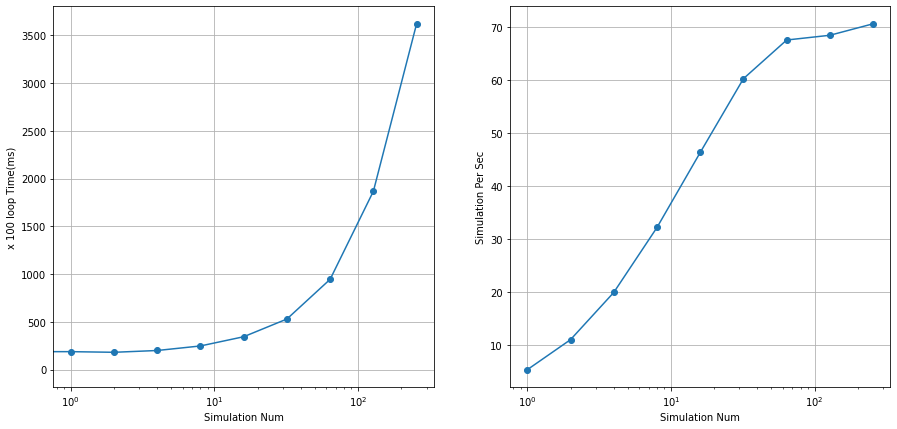

In [14]:
N_plot = 9
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
ax.set_xscale("log", nonposx='clip')
ax.plot([0]+N_all[:N_plot], [0]+time_vec[:N_plot],'-o')
plt.xlabel("Simulation Num")
plt.ylabel("x 100 loop Time(ms)")
plt.grid()
ax = plt.subplot(1,2,2)
ax.set_xscale("log", nonposx='clip')
ax.plot(N_all[:N_plot], np.divide(N_all[:N_plot],time_vec[:N_plot])*1000,'-o')
plt.xlabel("Simulation Num")
plt.ylabel("Simulation Per Sec")
plt.grid()
np.savetxt("cpu_N_all.csv", N_all, delimiter=',')
np.savetxt("cpu_time_vec.csv", time_vec, delimiter=',')

# saved plot: GPU case

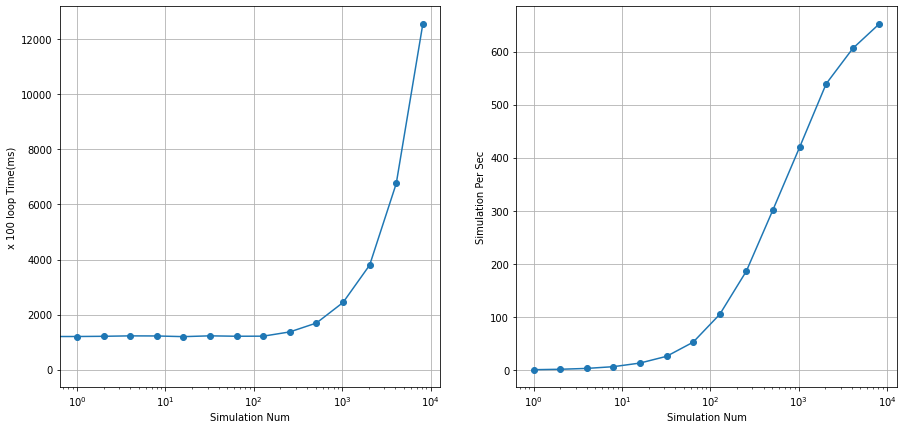

In [10]:
N_plot = 14
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
ax.set_xscale("log", nonposx='clip')
ax.plot([0]+N_all[:N_plot], [0]+time_vec[:N_plot],'-o')
plt.xlabel("Simulation Num")
plt.ylabel("x 100 loop Time(ms)")
plt.grid()
ax = plt.subplot(1,2,2)
ax.set_xscale("log", nonposx='clip')
ax.plot(N_all[:N_plot], np.divide(N_all[:N_plot],time_vec[:N_plot])*1000,'-o')
plt.xlabel("Simulation Num")
plt.ylabel("Simulation Per Sec")
plt.grid()
# np.savetxt("gpu_N_all.csv", N_all, delimiter=',')
# np.savetxt("gpu_time_vec.csv", time_vec, delimiter=',')

# Draw saved all

In [15]:
cpu_N_all = np.loadtxt("cpu_N_all.csv", delimiter=',')
cpu_time_vec = np.loadtxt("cpu_time_vec.csv", delimiter=',')
gpu_N_all = np.loadtxt("gpu_N_all.csv",  delimiter=',')
gpu_time_vec = np.loadtxt("gpu_time_vec.csv", delimiter=',')

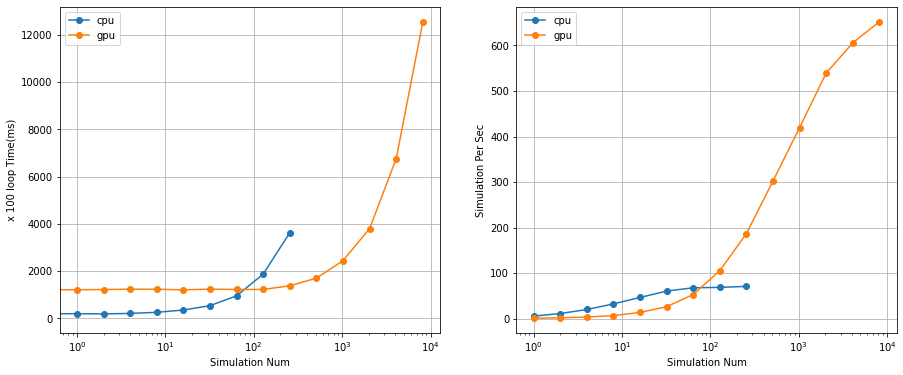

In [16]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1,2,1)
ax.set_xscale("log", nonposx='clip')
ax.plot(np.pad(cpu_N_all, [[1,0]]), np.pad(cpu_time_vec, [[1,0]]),'-o')
ax.plot(np.pad(gpu_N_all, [[1,0]]), np.pad(gpu_time_vec, [[1,0]]),'-o')
plt.xlabel("Simulation Num")
plt.ylabel("x 100 loop Time(ms)")
plt.legend(["cpu", "gpu"])
plt.grid()
ax = plt.subplot(1,2,2)
ax.set_xscale("log", nonposx='clip')
ax.plot(cpu_N_all, np.divide(cpu_N_all,cpu_time_vec)*1000,'-o')
ax.plot(gpu_N_all, np.divide(gpu_N_all,gpu_time_vec)*1000,'-o')
plt.xlabel("Simulation Num")
plt.ylabel("Simulation Per Sec")
plt.legend(["cpu", "gpu"])
plt.grid()

# Gradient Clipping

In [16]:
gtimer.reset()
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
gtimer.tic("assign")
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
gtimer.toc("assign")
print(gtimer)

assign: 	6.0 ms/1 = 5.57 ms 



In [17]:
gtimer.reset()
gtimer.tic("func")
T_all, Tbo_all = graph(None)
Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
jac_r, jac_o = graph.jacobian(T_all, Tbo_all)
dist_all, flag_all, vec_all, mask_all = graph.col_cal.calc_all(Tbo_all_res)
jac_d = graph.col_cal.jacobian(jac_o, vec_all)
gtimer.toc("func")
# gtimer.tic("grad")
# # Compute gradients.
# # gradients = g.gradient(loss, trainable_variables)
# # jacobian = g.batch_jacobian(loss, trainable_variables[0])
# gtimer.toc("grad")
# gradients = tf.unstack(clip_gradient(gradients, max_gradient))

# # Update W and b following gradients.
gtimer.tic("apply")
# graph.optimizer.apply_gradients(zip(gradients, graph.trainable_variables))
gtimer.toc("apply")
print(gtimer)

func: 	11.0 ms/1 = 10.72 ms 
apply: 	0.0 ms/1 = 0.019 ms 



# test full gradient

In [143]:
@tf.function
def test_grad(res):
    with tf.GradientTape() as g:
        # Forward pass.
        T_all, Tbo_all = graph(None)
        Tbo_all_res = tf.reshape(Tbo_all, (graph.N_sim, 1, graph.num_objects, 1, 4,4))
        dist, flag, mask = graph.dcal.calc_all(Tbo_all_res)
#         dist = dist*mask
#         loss = [tf.gather(dist, i_sim) for i_sim in range(N_sim)]
    #     loss = K.sum(dist[6])
    # Variables to update, i.e. trainable variables

    # Compute gradients.
    jacobian = g.batch_jacobian(dist, graph.trainable_variables[0])
    return K.sum(jacobian)
#     bjac = g.batch_jacobian(dist, graph.trainable_variables[0])
#     return bjac
gradients = test_grad(0)

In [ ]:
@ tf.function
def loop_grad():
    N_loop=100
    res = tf.while_loop(
        lambda value: True, test_grad, (tf.constant(0.0),), 
        parallel_iterations=10, maximum_iterations=N_loop
    )
    return res
loop_grad()

In [ ]:
gtimer.reset()
gtimer.tic("func")
jacobian = loop_grad()
gtimer.toc("func")
# gradients = tf.unstack(clip_gradient(gradients, max_gradient))

# # Update W and b following gradients.
gtimer.tic("apply")
# graph.optimizer.apply_gradients(zip(gradients, graph.trainable_variables))
gtimer.toc("apply")
print(gtimer)
# print(gradients.shape)

# SGD Optimizer

In [133]:
Q_ = np.array([tuple(ZERO_JOINT_POSE+(np.random.rand(DOF)*2-1)*np.pi/100) for _ in range(N_sim)], dtype=np.float32)
Ttar_ = SE3(Rot_zyx(0,0,np.pi),(0.5,0,0.00)).astype(np.float32)
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)

In [292]:
time_vec = []
Q_list = [list(map(lambda x: x.numpy(), graph.get_Q()))]
# Tbo_all_list = [np.array([[gframe_dict[gitem.name].Toff for gitem in gitem_list]]*N_sim)]
N_iter = 100
# Run training for the given number of steps.
Qtar, binQ, Ttar, binT = (np.zeros((N_sim, DOF), dtype='float32'), np.zeros(N_sim, dtype='float32'),
                      np.array([Ttar_]*N_sim), np.ones(N_sim, dtype='float32'))
dist_list = []
loss_list = []
jl_loss_list = []
jc_loss_list = []
fc_loss_list = []
cl_loss_list = []
gradients_list = []
gtimer.reset()
for _ in range(N_iter):
    # Run the optimization to update W and b values.
    T_all, Tbo_all = graph(None)
    #dist_list += [K.min(graph.test_collision(T_all, Tbo_all)[0]).numpy()]
    jl_loss = graph.calc_joint_limit()
    jc_loss = graph.joint_constraint((Qtar, binQ))
    fc_loss = graph.frame_constraint((T_all[:,-1,:,:],Ttar, binT))
    #cl_loss = graph.calc_collision_loss(T_all, Tbo_all)
    gtimer.tic("update")
    loss = graph.update_once(Qtar, binQ, Ttar, binT, max_gradient=10)
#     max_gradient=10

#     with tf.GradientTape() as g:
#         # Forward pass.
#         loss = graph.forward(Qtar, binQ, Ttar, binT)

#     # Variables to update, i.e. trainable variables.
#     trainable_variables = graph.trainable_variables

#     # Compute gradients.
#     gradients = g.gradient(loss, trainable_variables)
#     gradients = tf.unstack(clip_gradient(gradients, max_gradient))

#     # Update W and b following gradients.
#     graph.optimizer.apply_gradients(zip(gradients, graph.trainable_variables))
    gtimer.toc("update")
    gtimer.tic("record")
    Q_list += [graph.get_Q().numpy()]
    loss_list += [loss]
#     gradients_list += [gradients]
    jl_loss_list += [jl_loss]
    jc_loss_list += [jc_loss]
    fc_loss_list += [fc_loss]
    #cl_loss_list += [cl_loss]
    gtimer.toc("record")
#     if isnan(dist_list[-1]) or dist_list[-1]<0:
#         break
gtimer.print_time_log()
print("loss: {}".format(loss))

update: 	110.0 ms/100 = 1.095 ms
record: 	19.0 ms/100 = 0.19 ms
loss: 9.515193939208984


# Plot result

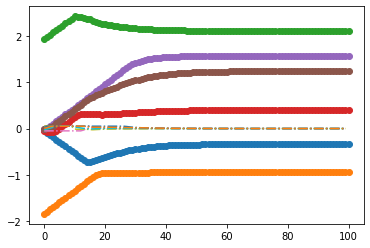

In [140]:
i_sim = 0
i_iter = 0
Q_all = np.array(Q_list)
Q_all_i = np.array([Q_all[i_iter, i_sim,:] for i_iter in range(len(Q_list))])
plt.plot(Q_all_i,'-o')
plt.plot(Q_all_i[1:,:]-Q_all_i[:-1,:],'-.')

In [ ]:
plt.plot(dist_list, label="distance")

In [ ]:
plt.plot(loss_list, label="total")
plt.plot(np.multiply(jl_loss_list, graph.alpha_jl), label="joint limit")
plt.plot(np.multiply(jc_loss_list, graph.alpha_jc), label="joint target")
plt.plot(np.multiply(fc_loss_list, graph.alpha_fc), label="frame target")
plt.plot(np.multiply(cl_loss_list, graph.alpha_cl), label="collision dist")
plt.legend()
axes = plt.gca()
# axes.set_ylim([-1e1,5e1])
# axes.set_xlim([0,1e1])

# Show rviz

In [293]:
q = Q_[0]
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q[2:-1]]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# Display motion

In [294]:
for i_sim in range(1): # N_sim):
    for i_iter in range(0,len(Q_list)):
        q = Q_list[i_iter][i_sim]
        gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
        pose_list = [q]
        gframevec_list = [gframevec]
        show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
        time.sleep(10e-2)

# Collision error case 

In [ ]:
Q_error = np.loadtxt("Q_error.csv",delimiter=",",dtype=np.float32)
graph.assign_Q(Q_error)
graph.assign_frame_dict(gframe_dict_list)

T_all, Tbo_all = graph(None)
dist = K.min(graph.test_collision(T_all, Tbo_all)[0]).numpy()
cl_loss = graph.calc_collision_loss(T_all, Tbo_all)
print("dist: {}".format(dist))

In [ ]:
q = Q_error[0]
gframevec = [gframe_dict[mk.geometry.name] for mk in marker_list]
pose_list = [q[2:-1]]
gframevec_list = [gframevec]
show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)

# Plot 3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(1,1,1,projection="3d")
sub.plot(x,y,z)
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0., azim=0)